In [1]:
import numpy as np
import codecs
import os
import pandas
from gensim.models import KeyedVectors
import re

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import doremus_data
from random import randint

In [2]:
# input
IN_PATH = 'embeddings/musedata.emb'
DOREMUS_PATH = 'music-embeddings/'

# output
IMG_PATH = './img'
DATASET_PATH = './dataset'

doremus_data.init(None, DOREMUS_PATH)

In [3]:
itl = pandas.read_csv('embeddings/musedata-interlink.csv')
itl = itl.astype({"mvt": str})
itl.head()

,midi,mvt,doremus
0,http://purl.org/midi-ld/pattern/cbac9e6462f740...,1. Coro,http://data.doremus.org/expression/23d9eec8-62...
1,http://purl.org/midi-ld/pattern/c089cc3b07e124...,2. Recitativo,http://data.doremus.org/expression/23d9eec8-62...
2,http://purl.org/midi-ld/pattern/8eef41ee2e10dd...,3. Aria,http://data.doremus.org/expression/23d9eec8-62...
3,http://purl.org/midi-ld/pattern/f968ebb5dc02c6...,4. Recitativo,http://data.doremus.org/expression/23d9eec8-62...
4,http://purl.org/midi-ld/pattern/b54056670ff161...,6. Choral,http://data.doremus.org/expression/23d9eec8-62...


In [4]:
len(itl)

438

In [5]:
def midi2doremus(midi):
    return itl.loc[itl['midi'] == midi]['doremus'].values[0]

midi2doremus('http://purl.org/midi-ld/pattern/7a6e0863caf80b1f932bbd8249c9be91')

'http://data.doremus.org/expression/ce2be9cf-17c7-33fa-8e98-93b969795b74'

In [6]:
from SPARQLTransformer import sparqlTransformer

stOpt = {'endpoint': 'http://data.doremus.org/sparql'}
def get_metadata(uri):
    query = {
        'proto':{
            'id': '?id',
            'label': '$rdfs:label$required$sample',
            'genre': '$mus:U12_has_genre/skos:prefLabel$bestlang',
            'key': '$mus:U11_has_key/skos:prefLabel$bestlang',
            'instrument': {
              'id':'$mus:U13_has_casting/mus:U23_has_casting_detail/mus:U2_foresees_use_of_medium_of_performance',
              'value':'$skos:prefLabel$bestlang',
            },
            "composer": {
             "@id": "?composer",
             "value": "$foaf:surname$required$sample"
            },

        },
        "$lang": "en",
       "$where": [
         "?expCreation efrbroo:R17_created ?id; ecrm:P9_consists_of / ecrm:P14_carried_out_by ?composer"
        ],
        '$values': {
            'id': uri
        }
    }
    return sparqlTransformer(query,stOpt)[0]

example = itl['doremus'].iloc[0]
get_metadata(example)

{'id': 'http://data.doremus.org/expression/23d9eec8-6240-3852-8d40-a9fd978200b5',
 'label': 'Wie schön leuchtet der Morgenstern',
 'genre': {'language': 'en', 'value': 'cantata'},
 'composer': {'@id': 'http://data.doremus.org/artist/269cec9d-5025-3a8a-b2ef-4f7acb088f2b',
  'value': 'Bach'}}

In [7]:
midi_embedding = KeyedVectors.load_word2vec_format(IN_PATH)

uris = list(filter(lambda x: x.startswith('http://purl.org/midi-ld/pattern/'), midi_embedding.index2entity))

uris[0:10]

['http://purl.org/midi-ld/pattern/7a6e0863caf80b1f932bbd8249c9be91',
 'http://purl.org/midi-ld/pattern/c60bd4e034f2371253afb1e148e4f521',
 'http://purl.org/midi-ld/pattern/223306be2b5c3c630ea9a15a12769ee5',
 'http://purl.org/midi-ld/pattern/2b08adbcaead9835cc1c41b535399451',
 'http://purl.org/midi-ld/pattern/cf99fafc3ca77b90f638aa79681ab4f2',
 'http://purl.org/midi-ld/pattern/51cebf35d767301c8c45a656007c22b7',
 'http://purl.org/midi-ld/pattern/c9c7d8c4846344336032256421b87dd7',
 'http://purl.org/midi-ld/pattern/d1ea599822900d30f79fc9b8e91957f9',
 'http://purl.org/midi-ld/pattern/c4de0fe7f49542a45442035e33cf8b36',
 'http://purl.org/midi-ld/pattern/c4f5b070421f16a4ee3ead6beb0d6991']

In [8]:
vectors = [midi_embedding.get_vector(k) for k in uris]
entities = [get_metadata(midi2doremus(k)) for k in uris]

In [9]:
composers = [k['composer']['value'] for k in entities]
labels = [k['label']['value'] if 'value' in k['label'] else k['label'] for k in entities]
unique_composers = list(set(composers))
unique_composers

['Bach', 'Haydn', 'Mozart', 'Beethoven']

In [10]:
def randcolor():
    return '#{:06x}'.format(randint(0, 256**3))

In [11]:
tempos = [
       'Adagio',
       'Allegretto',
       'Allegro',
       'Andante',
       'Largo',
       'Presto',
       'Vivace']

mvt_whitelist = [
    'Aria', 'Choral', 'Duetto', 'Finale', 'Fugue', 
    'Prelude', 'Recitativo', 'Minuetto', 'Rondeau'
]

def clean_mvt(x):
    x = re.sub(r'^\d+[..]', '', x).strip()
    x = re.sub(r'(SECONDA|PRIMA) PARTE:', '', x.strip()).strip()
    x = re.sub(r'^\d+[..]', '', x).strip()

    x = re.sub(r'[\[\(].+[\]\)]', '', x).strip()
    x = re.sub(r'\.$', '', x)
    x = re.sub(r' in [A-Za-z-\/]+ M(aj|in)or', '', x)
    x = re.sub(r'Finale ?:', '', x).strip()
    x = re.sub(r'Recit$', 'Recitativo', x).strip()
    x = re.sub(r' -+ ', '-', x).strip()
    x = re.sub(r'--+', '-', x).strip()
    x = re.sub(r' I+$', '', x).strip()
    x = re.sub(r' \d$', '', x).strip()

    if x == 'n.a':
        return '?'
    x = x.split(':')[0].strip()
    x = x.split('.')[0].strip()
    x = x.split('a 2')[0].strip()
    
    if 'Menuetto' in x or 'Minuetto' in x:
        x = 'Minuetto'
    if 'Recitativ' in x:
        x = 'Recitativo'
    if 'Rond' in x:
        x = 'Rondeau'

    
    if '-' in x:
        x =  x.split('-')[1]
    
    if 'Adagio' in x:
        x = 'Adagio'
    if 'Allegr' in x:
        x = 'Allegro'
    if 'Vivace' in x:
        x = 'Allegro'
    if 'Presto' in x:
        x = 'Allegro'
        
    if 'Chor' in x or 'Coro' in x:
        x = 'Choral'
    
    x = re.compile('\s').split(x.strip())[0]
    
    return x if x else '?'
#     return x if x in mvt_whitelist else '?'


def clean_genre(x, label):
    x = x.strip()
    if x == 'sinfonia':
        return 'symphony'
    if x in ['other form','?']:
        x = ''

    if not x :
        if 'Sinfonia' in label:
            return 'symphony'
        if 'Quatuor' in label:
            return 'quartet'
        if 'Invention' in label:
            return 'prelude'

    return '?' if not x else x

voices = ['alto', 'soprano', 'tenor', 'bariton', 'bass']
def clean_instr(x):
    if not x: 
        return '?'
    x = x.lower()
    
    if 'orchestra' in x:
        return 'O'
    
    if 'choir' in x or x in voices:
        return 'V'
    
    if 'piano' in x or x in ['piano', 'keyboard', 'continuo', 'organ']:
        return 'P'
    
    if 'viol' in x or 'cordes' in x  or x in ['double bass', 'cello']:
        return 'I'
    
    return 'I'

def clean_instrument(listing):    
    listing =  [clean_instr(l) for l in listing]
    
    if len(listing) > 5:
        return ['O'];

    listing =  list(np.unique([x for x in listing if x is not None]))
    

    if 'O' in listing:
        if 'I' in listing: 
            listing.pop(listing.index('I'))
            listing.append('S')            
        if 'P' in listing: 
            listing.pop(listing.index('P'))
            listing.append('S')            

    return listing

In [12]:
def extract(what, x):
    label = '' if what not in x else x[what]
    
    if not isinstance(label, list):
        label = [label]
    
    label = list(map(lambda l: l['value'] if 'value' in l else l, label))
    label = list(map(lambda l: l['value'] if 'value' in l else l, label))

    if what is 'genre':
        title = extract('label',x)
        label = [clean_genre(l, title) for l in label]
    elif what is 'instrument':
        label = clean_instrument(label)

    if len(label) == 0:
        return '?'
        
    label = list(set(label))
    label.sort()
    label = '+'.join(label)
    return label if label else '?' 

Clean the data for Tensorflow

In [13]:
def vec_to_string(vector):
    return ' '.join([str(v) for v in vector])

In [14]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

with open('%s/uri_midi.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join(uris)) 

with open('%s/uri_doremus.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([midi2doremus(k) for k in uris]))
    
with open('%s/vectors.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([vec_to_string(vector) for vector in vectors])) 

with open('%s/composer.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([extract('composer', entity) for entity in entities])) 
    
with open('%s/genre.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([extract('genre', entity) for entity in entities])) 

with open('%s/key.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([extract('key', entity) for entity in entities]))

with open('%s/instrument.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([extract('instrument', entity) for entity in entities])) 

with open('%s/mvt.txt' % DATASET_PATH, 'w') as f: 
    mvts = [itl[itl['midi']==u].iloc[0]['mvt'] for u in uris]
    f.write('\n'.join([clean_mvt(m) for m in mvts])) 

with open('%s/label.txt' % DATASET_PATH, 'w') as f: 
    f.write('\n'.join([extract('label', entity) for entity in entities])) 

In [13]:
vectors = normalize(vectors, 'l2')

In [29]:
colors = ['#D50000', '#304FFE', '#00C853', '#AA00FF']
import seaborn as sns

def plot(show=False, what='composer', map_color=False):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
#     plt.scatter(x_coords, y_coords, alpha=0)

    
# #     if not show:
#     plt.rcParams.update({'font.size': 1})

    curlabels = list(map(lambda x: extract(what, x), entities))
    
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1)
    sns.set_style("white")
    sns.scatterplot(
        x=x_coords, y=y_coords,
        hue=curlabels,
        palette=sns.color_palette("hls", len(np.unique(curlabels))),
        # data=df.loc[rndperm,:],
        legend="full",
        alpha=0.7
    )

#     if what == 'mvt':
#         curlabels = [itl[itl['midi']==u].iloc[0]['mvt'] for u in uris]
#         curlabels = [clean_mvt(x) for x in curlabels]
#     elif what == 'id':
#         curlabels = [re.sub(r'http:\/\/data.doremus.org\/expression\/', '', x) for x in curlabels]

    
#     curcomposers = list(map(lambda x: extract('composer', x), entities))
#     if map_color:
#         _unique_labels = list(set(curlabels))
#         _colors = list(map(lambda x: randcolor(), _unique_labels))
#     else:
#         _unique_labels = unique_composers
#         _colors = colors
    
#     for i, value in enumerate(zip(curlabels, curcomposers, uris, x_coords, y_coords)):
#         label, composer, uri, x, y = value

#         if label in _unique_labels:
#             c = _colors[_unique_labels.index(label)]
#         else:
#             c = _colors[_unique_labels.index(composer)]

#         if what != 'composer':
#             label = curlabels[i]
#             if map_color:
#                 if what == 'key':
#                     c = colors[0] if label.lower().endswith('major') else colors[1]
#                 else:
#                     c = _colors[_unique_labels.index(label)]

#         plt.text(x, y, label, color=c)
#     plt.xlim(x_coords.min() + 0.00005, x_coords.max() + 0.00005)
#     plt.ylim(y_coords.min() + 0.00005, y_coords.max() + 0.00005)

#     if show:
#         plt.show()
#     else:
#         if not os.path.exists(IMG_PATH):
#             os.makedirs(IMG_PATH)

    out = '%s/tsne-musedata-%s.pdf' % (IMG_PATH, what)
    plt.savefig(out, dpi=2400)
    print('Picture saved at %s' % out)

Picture saved at ./img/tsne-musedata-genre.pdf


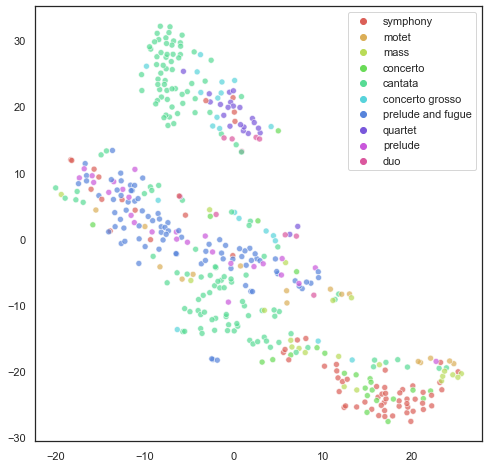

In [30]:
plot(what='genre', map_color=True)

In [24]:
# plot(what='id')

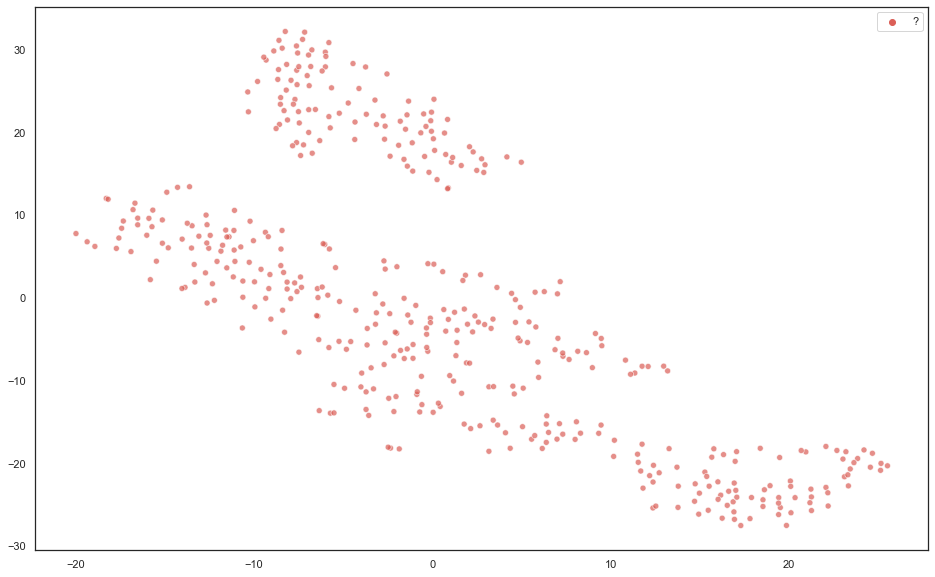

In [17]:
plot(what='mvt', map_color=True)

In [18]:
# plot(what='label')

Picture saved at ./img/tsne-musedata-composer.pdf


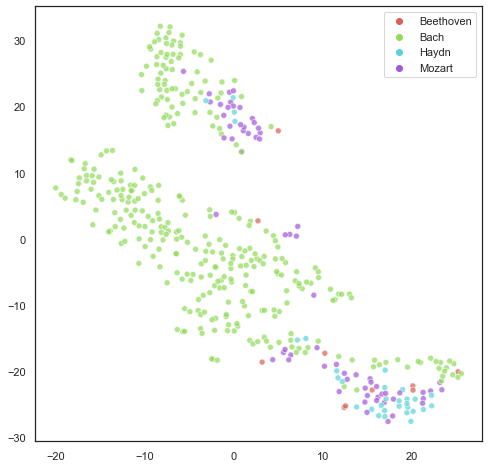

In [31]:
plot(what='composer')

In [20]:
# plot(what='key',map_color=True)

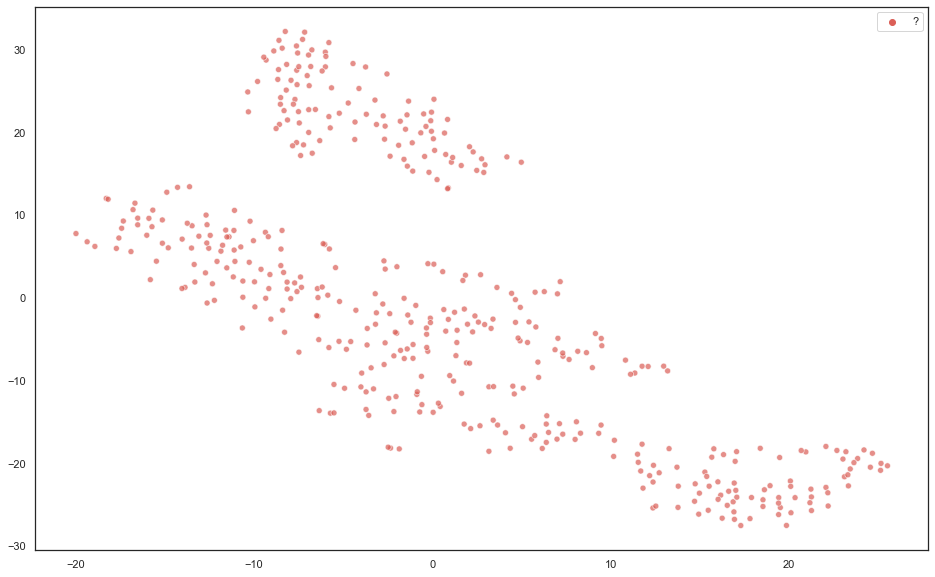

In [21]:
plot(what='instrument', map_color=True)

In [23]:
comp = [extract('composer', entity) for entity in entities]
np.unique(comp, return_counts=True)

(array(['Bach', 'Beethoven', 'Haydn', 'Mozart'], dtype='<U9'),
 array([332,  10,  31,  65]))